# Assignment 1

### Business Understanding

Introduction - The Iowa Liquor Sales dataset is an API from Google’s Bigquery which contains the spirits purchase detail of Iowa Class “E” liquor license holders by product, date of purchase, and location the item was purchased from. The timeframe of this data starts from January 1, 2012 through 2019. As part of the study commissioned by the Iowa Department of Commerce, all alcoholic sales within the state were logged into the Department system, and in turn, published as open data by the State of Iowa. The dataset contains detail on the name, product, quantity and location of the individual container or package sale. 

1. Set Objectives: We are a new and emerging Whisky brand who specializes in single-malt Rye, and we have targeted the state of Iowa for our next brand expansion. Before doing so, our goal will be to identify and predict which markets are more likely to sell greater volumes of whiskey, so that we can more efficiently spend our marketing dollars and inventory with little waste or buyback. Related questions also include, which brands are going to sell the most in each market, what parts of the year are going to have higher whiskey sales as opposed to lower whiskey sales to optimize advertising dollars, and what features of a town are defining characteristics of a large whiskey seller. 

2. Product Project Plan: To meet our goals, we will first use the Google Bigquery API to access the publicly available Iowa Liquor Sales data via python and Jupyter Notebook. Since the dataset is over 17 million lines of data, we will focus just on 2 months worth of data to do the cleaning. From here, we will define a subset to grant us 30,000 observations, address missing values and begin to build models that could help us answer questions based on markets likely to sell more whiskey. For our data on times of the year when we will sell more whiskey, we will need to create a subset of a full year’s data to build a time series model. For the town features, we will need to include additional information about the zip codes of iowa (such as population, income, ect) to get more demographic detail on each market to assist with a program for a clustering problem. For each of these problems, we will create a training and testing data set to help tune our predictions. 

3. Business Success Criteria - For our prediction models of market sales, we will be consider our model successful if we are able to classify our alochol type with a strong precision, recall and accuracy using a cross validation. Ideally, if we are dealing with 5 alcohol types, we will want to be able to predict whiskey accurately over 20% of the time. 

From the sale price prediction problem, we will run a linear regression technique against the remaining features. For this technique, we will use Root Mean Square Error to evaluate the effectiveness. A strong criteria for performance would be if we can get within $3 as an RMSE.

## Data Mining Type - Describe the meaning and type of data for each attribute in the data file

The data was collected via Google’s BigQuery tool in their Cloud Platform. The data was publicly available within the platform as an educational resource. The data is regularly updated through BigQuery, but .csv files can be found via sites like Kaggle.com. 

The description of all 24 fields of the data attributes can be found at https://data.iowa.gov/Sales-Distribution/Iowa-Liquor-Sales/m3tr-qhgy. We are working with the fields to start out with, to help begin the process of feature reduction and correlation analysis. Some of the data has no useful information for analysis, which we will likely be removing eventually. 

Below is a description of each feature available in the data set.

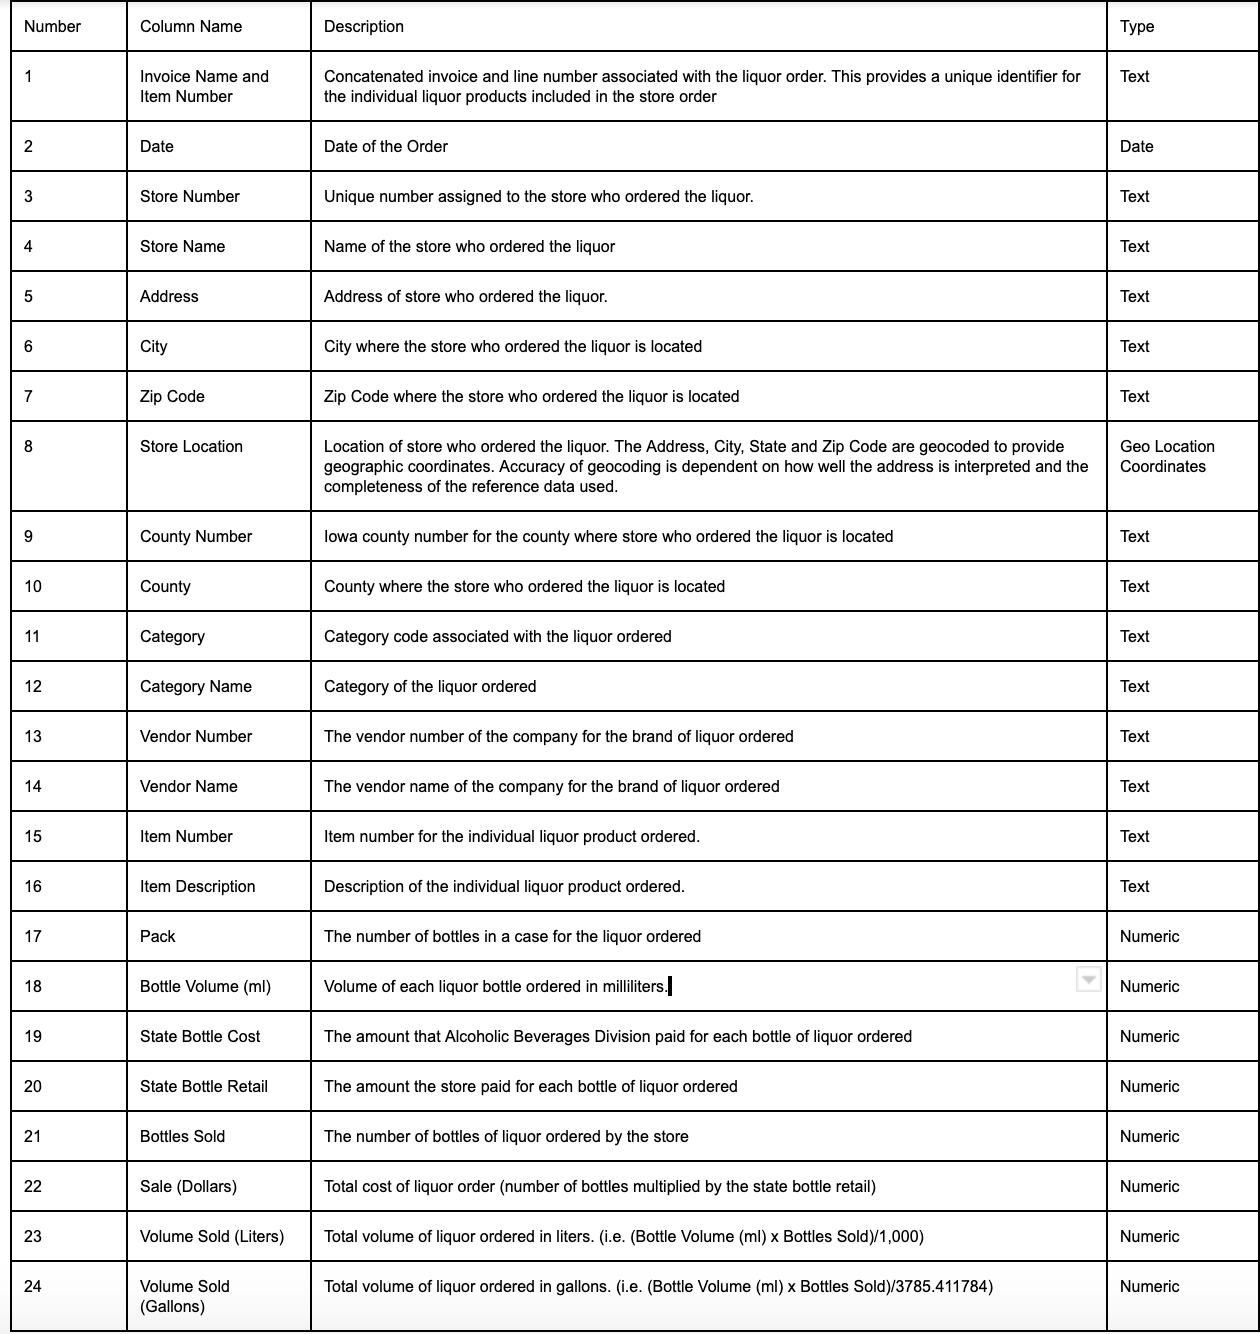

## Data Quality

In [3]:
# below is import of python packages.
try:
    from collections import abc as collections_abc
except ImportError:  # Python 2.7
    import collections as collections_abc

    import copy
import functools
import gzip
import io
import itertools
import json
import math
import os
import tempfile
import uuid
import warnings
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd
import numpy as np
#import altair as alt
import matplotlib.pyplot as plt
import re

# Imports the Google Cloud client library
#from google.cloud import storage
from google.oauth2 import service_account
from google.cloud import bigquery

### Load in the Data

In order to load in our data, we will need to create a project id and save in our .json credentials from BigQuery onto our local machine. From there, we can set the client variable to map the credentials to our service account in our bigquery program. 

In [2]:
#project = 'macro-campaign-202100'
#credentials = service_account.Credentials.from_service_account_file(r'/Users/danielclark/Desktop/SMU/data_mining/My Project-71c2d48ddfb0.json')
#project = 'flash-ward-264717'
#credentials = service_account.Credentials.from_service_account_file(r'/Users/jjsch/Downloads/My Project 35341-372d7a58bfb3.json')
#C:\Users\jjsch\Downloads


#client = bigquery.Client(credentials=credentials, project=project)


For our measurement, we will be querying the first two months of data in 2012 (from Jan 01 through March 01, 2012) using our SQL command limiting our data to the first 30,000 rows. 

In [46]:
#begindate = '2012-01-01'
#enddate = '2012-03-31'
  
#query = "select * FROM `bigquery-public-data.iowa_liquor_sales.sales` where date > '" +begindate + "' and date <= '" + enddate +"' --LIMIT " 
#df = client.query(query).to_dataframe()

df =  pd.read_csv(r'/Users/jjschued/Documents/Github/7331DataMiningNotebooks/lab1/iowa_subset_2019_400k_random_rows.csv', nrows = 50000)


In [5]:
df.info

<bound method DataFrame.info of       invoice_and_item_number        date  store_number  \
0             INV-23084400002  2019-11-07          3869   
1             INV-23282200001  2019-11-18          4617   
2             INV-19435800130  2019-05-17          2560   
3             INV-23454200002  2019-11-25          2614   
4             INV-23541200001  2019-11-27          2629   
...                       ...         ...           ...   
49995         INV-17241000143  2019-01-30          2616   
49996         INV-17382700010  2019-02-06          2548   
49997         INV-20839900001  2019-07-25          4509   
49998         INV-17608900026  2019-02-18          2575   
49999         INV-21188000001  2019-08-13          2535   

                                   store_name                     address  \
0                   Bootleggin' Barzini's Fin                412  1st Ave   
1                              Lickety Liquor            2501 HUBBELL AVE   
2                  Hy-Vee Fo

In [26]:
df.to_csv(index=False)

'f0_\n2380345\n'

In [47]:
df.columns.values

array(['invoice_and_item_number', 'date', 'store_number', 'store_name',
       'address', 'city', 'zip_code', 'store_location', 'county_number',
       'county', 'category', 'category_name', 'vendor_number',
       'vendor_name', 'item_number', 'item_description', 'pack',
       'bottle_volume_ml', 'state_bottle_cost', 'state_bottle_retail',
       'bottles_sold', 'sale_dollars', 'volume_sold_liters',
       'volume_sold_gallons'], dtype=object)

Running a df.columns.values function, confirms the 24 features that we referenced in our Data understanding phase. This now allows us to move forward with our data cleaning. 

### Data Cleaning

In our data cleaning step, we need to perform two specific data cleaning operations. 1.) We will need to convert our features to the correct continuous, ordinal and categorical features, and 2.) we will need to address the missing values. 

To begin the process of addressing missing values so that we can convert our data types, we will replace all "?", which our dataset denotes as null, into "-1" values (not strings). From here, we will convert state_bottle_cost, state_bottle_retail, sale_dollars, volume_sold_liters, and volume_sold_gallons into continuous variables so they register as floats. 


In addition, we will need to convert the varaible "bottles_sold" into ordinal features so they register as an integer value in our models. 

Thirdly, we will want to replace the values for pack, bottle_volume_ml, store_number, store_name, address, city, zip_code, county_number, county, category, category_name, vendor_number, vendor_name, item_number and item_description into categorical variables so they register as a non-null object in our model.

Using a df.info function helps to verify this. 

The following will do some cleanup on values and categorize store, category, and dates into more summarized values

In [48]:
df.dtypes

invoice_and_item_number     object
date                        object
store_number                 int64
store_name                  object
address                     object
city                        object
zip_code                   float64
store_location              object
county_number              float64
county                      object
category                   float64
category_name               object
vendor_number                int64
vendor_name                 object
item_number                  int64
item_description            object
pack                         int64
bottle_volume_ml             int64
state_bottle_cost          float64
state_bottle_retail        float64
bottles_sold                 int64
sale_dollars               float64
volume_sold_liters         float64
volume_sold_gallons        float64
dtype: object

In [49]:
#upper case category name for matching later
df['category_name'] = df['category_name'].str.upper()

In [50]:
df['category_name'][40:200]

40     TEMPORARY & SPECIALTY PACKAGES
41     TEMPORARY & SPECIALTY PACKAGES
42                         TRIPLE SEC
43                  IMPORTED DRY GINS
44                  IMPORTED DRY GINS
                    ...              
195                 IMPORTED DRY GINS
196    TEMPORARY & SPECIALTY PACKAGES
197                 IMPORTED DRY GINS
198                 IMPORTED DRY GINS
199    TEMPORARY & SPECIALTY PACKAGES
Name: category_name, Length: 160, dtype: object

In [51]:
#convert nan to blanks
df = (df.replace(r'^\s*$', np.nan, regex=True))

In [52]:
df = (df.replace(np.nan, 'blank', regex=True))

In [53]:
#download to categorize in more summarized manner
#liquortcatlistdf.to_csv("C:\\Users\\jjsch\\downloads\\liquorcats.csv")    
#import the file
#liquortcatlistdf = pd.read_csv("C:\\Users\\jjsch\\downloads\\liquorcats.csv")
#liquortcatlistdf = pd.read_csv("C:\\Users\\jjschued\\Documents\\SMU\\7331 Machine Learning\\Github\\7331DataMiningNotebooks\\liquorcats.csv")
#liquortcatlistdf.dtypes

#grouping all the store locations into parent stores
df['Category'] = 'Other'
df.loc[df['category_name'].str.contains('GINS'), 'Category'] = 'GIN'
df.loc[df['category_name'].str.contains('GINS'), 'Category'] = 'GIN'
df.loc[df['category_name'].str.contains('GIN'), 'Category'] = 'GIN'
df.loc[df['category_name'].str.contains('RUMS'), 'Category'] = 'RUM'
df.loc[df['category_name'].str.contains('RUM'), 'Category'] = 'RUM'
df.loc[df['category_name'].str.contains('SCOTCH'), 'Category'] = 'WHISKY'
df.loc[df['category_name'].str.contains('WHISKIES'), 'Category'] = 'WHISKY'
df.loc[df['category_name'].str.contains('WHISKY'), 'Category'] = 'WHISKY'
df.loc[df['category_name'].str.contains('WHISKEY'), 'Category'] = 'WHISKY'
df.loc[df['category_name'].str.contains('RYE'), 'Category'] = 'WHISKY'
df.loc[df['category_name'].str.contains('AMARETTO'), 'Category'] = 'AMARETTO'
df.loc[df['category_name'].str.contains('BOURBON'), 'Category'] = 'WHISKY'
df.loc[df['category_name'].str.contains('LIQUEURS'), 'Category'] = 'LIQUEUR'
df.loc[df['category_name'].str.contains('LIQUEUR'), 'Category'] = 'LIQUEUR'
df.loc[df['category_name'].str.contains('VODKAS'), 'Category'] = 'VODKA'
df.loc[df['category_name'].str.contains('VODKA'), 'Category'] = 'VODKA'
df.loc[df['category_name'].str.contains('BRANDY'), 'Category'] = 'BRANDY'
df.loc[df['category_name'].str.contains('BRANDIES'), 'Category'] = 'GIN'
df.loc[df['category_name'].str.contains('CREME'), 'Category'] = 'SCHNAPPS'
df.loc[df['category_name'].str.contains('SCHNAPPS'), 'Category'] = 'SCHNAPPS'
df.loc[df['category_name'].str.contains('TEQUILA'), 'Category'] = 'TEQUILA'
df.loc[df['category_name'].str.contains('TEQUILAS'), 'Category'] = 'TEQUILA'




In [54]:
#get a few stray not available categories per internet this is tequila
df.loc[df['item_description'] == 'Herradura Gold Reposado 6pak', 'Category'] = "Tequila"
df.loc[df['item_description'] == 'Chambord Liqueur w/2 Glasses', 'Category'] = "Liquers"

#grouping all the store locations into parent stores
df['store_parent'] = 'Other'
df.loc[df['store_name'].str.contains('Hy-Vee'), 'store_parent'] = 'Hy-Vee'
df.loc[df['store_name'].str.contains('Wal-Mart'), 'store_parent'] = 'Wal-Mart'
df.loc[df['store_name'].str.contains('SamsClub'), 'store_parent'] = 'SamsClub'
df.loc[df['store_name'].str.contains('Fareway'), 'store_parent'] = 'Fareway'
df.loc[df['store_name'].str.contains('Kum&Go'), 'store_parent'] = 'Kum&Go'
df.loc[df['store_name'].str.contains('CVS'), 'store_parent'] = 'CVS'
df.loc[df['store_name'].str.contains('Target'), 'store_parent'] = 'Target'
df.loc[df['store_name'].str.contains('Caseys'), 'store_parent'] = 'Caseys'
df.loc[df['store_name'].str.contains('Dahls'), 'store_parent'] = 'Dahls'
df.loc[df['store_name'].str.contains('WAL-MART'), 'store_parent'] = 'Wal-Mart'
df.loc[df['store_name'].str.contains('HY-VEE'), 'store_parent'] = 'Hy-Vee'
df.loc[df['store_name'].str.contains('KUM&GO'), 'store_parent'] = 'Kum&Go'
df.loc[df['store_name'].str.contains('QuikTrip'), 'store_parent'] = 'QuikTrip'


#labored conversion of dates to month year and month year by converting to strings
df['month'] = pd.DatetimeIndex(df['date']).month
df['year'] = pd.DatetimeIndex(df['date']).year

df.loc[df['month'] ==1 , 'month'] = 'Jan'
df.loc[df['month'] ==2 , 'month'] = 'Feb'
df.loc[df['month'] ==3 , 'month'] = 'Mar'
df.loc[df['month'] ==4 , 'month'] = 'Apr'
df.loc[df['month'] ==5 , 'month'] = 'May'
df.loc[df['month'] ==6 , 'month'] = 'Jun'
df.loc[df['month'] ==7 , 'month'] = 'Jul'
df.loc[df['month'] ==8 , 'month'] = 'Aug'
df.loc[df['month'] ==9 , 'month'] = 'Sep'
df.loc[df['month'] ==10 , 'month'] = 'Oct'
df.loc[df['month'] ==11 , 'month'] = 'Nov'
df.loc[df['month'] ==12 , 'month'] = 'Dec'


df.loc[df['year'] ==2012 , 'year'] = '2012'
df.loc[df['year'] ==2013 , 'year'] = '2013'
df.loc[df['year'] ==2014 , 'year'] = '2014'
df.loc[df['year'] ==2015 , 'year'] = '2015'
df.loc[df['year'] ==2016 , 'year'] = '2016'
df.loc[df['year'] ==2017 , 'year'] = '2017'
df.loc[df['year'] ==2018 , 'year'] = '2018'
df.loc[df['year'] ==2019 , 'year'] = '2019'

#merge year and month together
df['monthyear'] = df['month'] + "-" + df['year']

In [55]:
df.head(20)

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,...,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,Category,store_parent,month,year,monthyear
0,INV-23084400002,2019-11-07,3869,Bootleggin' Barzini's Fin,412 1st Ave,Coralville,52241,POINT (-91.565517 41.672672),52,JOHNSON,...,5.78,20,115.60,7.50,1.98,Other,Other,Nov,2019,Nov-2019
1,INV-23282200001,2019-11-18,4617,Lickety Liquor,2501 HUBBELL AVE,Des Moines,50317,POINT (-93.570489 41.607817),77,POLK,...,13.13,1,13.13,0.05,0.01,Other,Other,Nov,2019,Nov-2019
2,INV-19435800130,2019-05-17,2560,Hy-Vee Food Store / Marion,3600 Business Hwy 151 East,Marion,52302,blank,57,LINN,...,24.75,6,148.50,6.00,1.58,GIN,Hy-Vee,May,2019,May-2019
3,INV-23454200002,2019-11-25,2614,Hy-Vee #3 Food & Drugstore / Davenport,1823 E Kimberly Rd,Davenport,52807,POINT (-90.548919 41.55678100000001),82,SCOTT,...,31.76,24,762.24,18.00,4.75,WHISKY,Hy-Vee,Nov,2019,Nov-2019
4,INV-23541200001,2019-11-27,2629,Hy-Vee Food Store #2 / Council Bluffs,1745 Madison Ave,Council Bluffs,51503,POINT (-95.825137 41.242732),78,POTTAWATTA,...,13.97,12,167.64,21.00,5.54,Other,Hy-Vee,Nov,2019,Nov-2019
5,INV-23540300028,2019-11-27,4312,I-80 Liquor / Council Bluffs,2411 S 24TH ST #1,Council Bluffs,51501,POINT (-95.8792 41.238092),78,POTTAWATTA,...,43.47,6,260.82,6.00,1.58,WHISKY,Other,Nov,2019,Nov-2019
6,INV-19655400089,2019-05-29,2517,Hy-Vee Food Store #1 / Newton,1501 First Avenue East,Newton,50208,POINT (-93.034296 41.69916),50,JASPER,...,7.35,12,88.20,6.00,1.58,Other,Hy-Vee,May,2019,May-2019
7,INV-23687700099,2019-12-05,2545,Hy-Vee Drugstore / Iowa City,310 N 1st St,Iowa City,52245,POINT (-91.528105 42.207428),52,JOHNSON,...,12.75,30,382.50,22.50,5.94,Other,Hy-Vee,Dec,2019,Dec-2019
8,INV-17141800065,2019-01-25,5210,Ding's Honk'n Holler,"900, E Washington St",Clarinda,51632,POINT (-95.027238 40.739231),73,PAGE,...,13.13,2,26.26,0.60,0.15,Other,Other,Jan,2019,Jan-2019
9,INV-23109300014,2019-11-08,5411,Bluejay Market,2810 Wills Ave,Perry,50220,POINT (-94.081127 41.838488),25,DALLAS,...,50.01,6,300.06,6.00,1.58,Other,Other,Nov,2019,Nov-2019


In [56]:
import numpy as np
# replace '?' with -1, we will deal with missing values later
df = df.replace(to_replace='?',value=-1) 

categorical_features = ['city', 'county',  'category_name','vendor_name', 'store_number', 'item_description','store_parent', 
                        'monthyear', 'Category', 'county_number', 'vendor_number', 'item_number']

# let's start by first changing the numeric values to be floats
continuous_features = ['state_bottle_cost', 'state_bottle_retail', 'sale_dollars', 'volume_sold_liters', 'volume_sold_gallons', 'bottles_sold']

# and the oridnal values to be integers
ordinal_features = ['pack', 'bottle_volume_ml']

# use the "astype" function to change the variable type
df[continuous_features] = df[continuous_features].astype(np.float64)
df[ordinal_features] = df[ordinal_features].astype(np.int64)

df.info() # now our data looks better!!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 29 columns):
invoice_and_item_number    50000 non-null object
date                       50000 non-null object
store_number               50000 non-null int64
store_name                 50000 non-null object
address                    50000 non-null object
city                       50000 non-null object
zip_code                   50000 non-null object
store_location             50000 non-null object
county_number              50000 non-null object
county                     50000 non-null object
category                   50000 non-null object
category_name              50000 non-null object
vendor_number              50000 non-null int64
vendor_name                50000 non-null object
item_number                50000 non-null int64
item_description           50000 non-null object
pack                       50000 non-null int64
bottle_volume_ml           50000 non-null int64
state_bottle_c

In [16]:
dfstats = df.describe() # will get summary of continuous or the nominals

# let's set those values to NaN, so that Pandas understand they are missing
df = df.replace(to_replace=-1,value=np.nan) # replace -1 with NaN (not a number)
print (df.info())
dfstats2 = df.describe() # scroll over to see the values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 29 columns):
invoice_and_item_number    50000 non-null object
date                       50000 non-null object
store_number               50000 non-null int64
store_name                 50000 non-null object
address                    50000 non-null object
city                       50000 non-null object
zip_code                   50000 non-null object
store_location             50000 non-null object
county_number              50000 non-null object
county                     50000 non-null object
category                   50000 non-null object
category_name              50000 non-null object
vendor_number              50000 non-null int64
vendor_name                50000 non-null object
item_number                50000 non-null int64
item_description           50000 non-null object
pack                       50000 non-null int64
bottle_volume_ml           50000 non-null int64
state_bottle_c

From here, we are going to drop the following variables due to the fact that they will not play a factor in our prediction dataset. Rationale is below:

- store_name : removing due to avail of store_number variable, which will identify the specific store more succinctly
- store location: as we will be able to locate stores on zip code, city and county number, and there appears to be a bunch of nulls anyway.

In [17]:
dfna = df[df.isna().any(axis=1)]
dfna.isna().sum()

invoice_and_item_number    0
date                       0
store_number               0
store_name                 0
address                    0
city                       0
zip_code                   0
store_location             0
county_number              0
county                     0
category                   0
category_name              0
vendor_number              0
vendor_name                0
item_number                0
item_description           0
pack                       0
bottle_volume_ml           0
state_bottle_cost          0
state_bottle_retail        0
bottles_sold               0
sale_dollars               0
volume_sold_liters         0
volume_sold_gallons        0
Category                   0
store_parent               0
month                      0
year                       0
monthyear                  0
dtype: int64

Once we drop our store name, address, and store location variables, we can also look to address the county number nulls as well. Since 112 values is somewhat significant on a 30,000 value dataset, we can look to do some inputation with the other data. 

Since we can use city and zip code as a guide, let's take the values that appear in the respective city and zip code on other values, and replace it with the missing value. 

In [18]:
#Unique Value Threshold (Per Column)
#Delete Columns >  uniqueThreshold unique values prior to one-hot encoding. 
#(each unique value becomes a new column during one-hot encoding)
uniqueThreshold = 30
# in each column of dataframe
uniqueValues = df.nunique()
#Isolate continuous and categorical data types
#These are indexers into the schoolData dataframe and may be used similar to the schoolData dataframe 
D_boolean = df.loc[:, (df.dtypes == bool) ]
D_nominal = df.loc[:, (df.dtypes == object)]
D_continuous = df.loc[:, (df.dtypes != bool) & (df.dtypes != object)]
print ("Boolean Columns: ", D_boolean.shape[1])
print ("Nominal Columns: ", D_nominal.shape[1])
print ("Continuous Columns: ", D_continuous.shape[1])
print ("Columns Accounted for: ", D_nominal.shape[1] + D_continuous.shape[1] + D_boolean.shape[1])

#Delete categorical columns with > 30 unique values (Each unique value becomes a column during one-hot encoding)
oneHotUniqueValueCounts = df[D_nominal.columns].apply(lambda x: x.nunique())
oneHotUniqueValueCols = oneHotUniqueValueCounts[oneHotUniqueValueCounts >= uniqueThreshold].index
df.drop(oneHotUniqueValueCols, axis=1, inplace=True) 

Boolean Columns:  0
Nominal Columns:  18
Continuous Columns:  11
Columns Accounted for:  29


In [42]:
df.head()

,invoice_and_item_number,date,store_name,address,city,zip_code,store_location,county_number,county,category,...,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,Category,cost_per_liter,store_parent,month,year,monthyear
0,INV-23084400002,2019-11-07,Bootleggin' Barzini's Fin,412 1st Ave,Coralville,52241,POINT (-91.565517 41.672672),52,JOHNSON,1.0921e+06,...,20,115.60,7.50,1.98,Other,15.413333,Other,Nov,2019,Nov-2019
1,INV-23282200001,2019-11-18,Lickety Liquor,2501 HUBBELL AVE,Des Moines,50317,POINT (-93.570489 41.607817),77,POLK,1.0913e+06,...,1,13.13,0.05,0.01,Other,262.600000,Other,Nov,2019,Nov-2019
2,INV-19435800130,2019-05-17,Hy-Vee Food Store / Marion,3600 Business Hwy 151 East,Marion,52302,blank,57,LINN,1.0421e+06,...,6,148.50,6.00,1.58,GIN,24.750000,Hy-Vee,May,2019,May-2019
3,INV-23454200002,2019-11-25,Hy-Vee #3 Food & Drugstore / Davenport,1823 E Kimberly Rd,Davenport,52807,POINT (-90.548919 41.55678100000001),82,SCOTT,1.0113e+06,...,24,762.24,18.00,4.75,WHISKY,42.346667,Hy-Vee,Nov,2019,Nov-2019
4,INV-23541200001,2019-11-27,Hy-Vee Food Store #2 / Council Bluffs,1745 Madison Ave,Council Bluffs,51503,POINT (-95.825137 41.242732),78,POTTAWATTA,1.9012e+06,...,12,167.64,21.00,5.54,Other,7.982857,Hy-Vee,Nov,2019,Nov-2019


In [20]:
df[df.isnull().any(axis=1)][df.columns[df.isnull().any()]]

""


In [39]:
#one hot encoding

df = df.drop(columns=['vendor_number', 'item_number', 'store_number'])
#'month', 'year', 'county_number',
#Isolate continuous and categorical data types
#These are indexers into the schoolData dataframe and may be used similar to the schoolData dataframe 
D_boolean = df.loc[:, (df.dtypes == bool) ]
D_nominal = df.loc[:, (df.dtypes == object)]
D_continuous = df.loc[:, (df.dtypes != bool) & (df.dtypes != object)]
print ("Boolean Columns: ", D_boolean.shape[1])
print ("Nominal Columns: ", D_nominal.shape[1])
print ("Continuous Columns: ", D_continuous.shape[1])
print ("Columns Accounted for: ", D_nominal.shape[1] + D_continuous.shape[1] + D_boolean.shape[1])

one_hot_df = pd.concat([pd.get_dummies(df[col],prefix=col) for col in D_nominal.columns], axis=1)
one_hot_df.head()

Boolean Columns:  0
Nominal Columns:  18
Continuous Columns:  9
Columns Accounted for:  27


,invoice_and_item_number_INV-16676600002,invoice_and_item_number_INV-16676600008,invoice_and_item_number_INV-16676700003,invoice_and_item_number_INV-16676700038,invoice_and_item_number_INV-16677000013,invoice_and_item_number_INV-16677100023,invoice_and_item_number_INV-16677300023,invoice_and_item_number_INV-16677600009,invoice_and_item_number_INV-16677600013,invoice_and_item_number_INV-16677800036,...,monthyear_Dec-2019,monthyear_Feb-2019,monthyear_Jan-2019,monthyear_Jul-2019,monthyear_Jun-2019,monthyear_Mar-2019,monthyear_May-2019,monthyear_Nov-2019,monthyear_Oct-2019,monthyear_Sep-2019
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [43]:
dfstats2

,store_number,vendor_number,item_number,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,3685.072080,289.595480,63733.903480,11.772740,871.934060,13.394573,20.094518,11.510400,169.250258,10.519123,2.773666
std,1145.870369,129.287495,135796.349481,8.244936,455.928174,11.745491,17.618159,42.463618,585.357263,55.927518,14.774748
min,2106.000000,35.000000,159.000000,1.000000,50.000000,0.890000,1.340000,1.000000,2.570000,0.050000,0.010000
25%,2602.000000,255.000000,28233.000000,6.000000,750.000000,5.380000,8.070000,2.000000,36.000000,1.500000,0.390000
50%,3663.000000,300.000000,37418.000000,12.000000,750.000000,11.040000,16.560000,6.000000,76.800000,4.500000,1.180000
75%,4721.000000,395.000000,65307.000000,12.000000,1000.000000,18.090000,27.140000,12.000000,169.560000,10.500000,2.770000
max,9042.000000,978.000000,997095.000000,48.000000,6000.000000,262.460000,393.690000,2700.000000,37514.880000,4725.000000,1248.210000


In [25]:
df.head()

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,...,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,Category,cost_per_liter
0,INV-23084400002,2019-11-07,3869,Bootleggin' Barzini's Fin,412 1st Ave,Coralville,52241,POINT (-91.565517 41.672672),52,JOHNSON,...,20,375,3.85,5.78,20,115.60,7.50,1.98,Other,15.413333
1,INV-23282200001,2019-11-18,4617,Lickety Liquor,2501 HUBBELL AVE,Des Moines,50317,POINT (-93.570489 41.607817),77,POLK,...,8,50,8.75,13.13,1,13.13,0.05,0.01,Other,262.600000
2,INV-19435800130,2019-05-17,2560,Hy-Vee Food Store / Marion,3600 Business Hwy 151 East,Marion,52302,blank,57,LINN,...,12,1000,16.50,24.75,6,148.50,6.00,1.58,GIN,24.750000
3,INV-23454200002,2019-11-25,2614,Hy-Vee #3 Food & Drugstore / Davenport,1823 E Kimberly Rd,Davenport,52807,POINT (-90.548919 41.55678100000001),82,SCOTT,...,6,750,21.17,31.76,24,762.24,18.00,4.75,WHISKY,42.346667
4,INV-23541200001,2019-11-27,2629,Hy-Vee Food Store #2 / Council Bluffs,1745 Madison Ave,Council Bluffs,51503,POINT (-95.825137 41.242732),78,POTTAWATTA,...,6,1750,9.31,13.97,12,167.64,21.00,5.54,Other,7.982857


### Outliers

In [45]:
# this python magics will allow plot to be embedded into the notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline

In [25]:
df['Category'].value_counts()

VODKA      13027
WHISKY     10556
Other       9155
LIQUEUR     7007
RUM         5608
GIN         3101
TEQUILA     1546
Name: Category, dtype: int64

Looking at a quick boxplot of our 66 categories, along with the sale price, we can see there are a handfull of liquor sales that went north of $5,000, with two who have exceeded $25,000.

In [15]:
# selecting rows based on condition
exp_df = df[df['sale_dollars'] > 5000]

exp_df['cost_per_liter'] = exp_df['sale_dollars']/exp_df['volume_sold_liters']

print(exp_df[['sale_dollars', 'volume_sold_liters', 'cost_per_liter', 'Category']])

C:\ProgramData\Anaconda3\envs\ML7331\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


       sale_dollars  volume_sold_liters  cost_per_liter Category
89         13791.60              1890.0        7.297143    Other
168         5591.04               768.0        7.280000    Other
230        13791.60              1890.0        7.297143    Other
276        13791.60              1890.0        7.297143    Other
296         5591.04               768.0        7.280000    Other
...             ...                 ...             ...      ...
42761      13791.60              1890.0        7.297143    Other
42864       5591.04               768.0        7.280000    Other
42874       5591.04               768.0        7.280000    Other
42890       5758.80               210.0       27.422857    Other
42934       7017.00               225.0       31.186667    Other

[109 rows x 4 columns]


## Simple Statistics

The df.describe funciton below provides some simple statistcs for the numeric values in the table. 

We can see that the average pack size is just over 12, with a median of exactly 12, so this would suggest our normality curve is very narrow (verified with the SD of 7.3 bottles and slightly right-skewed towards higher pack sizes. 

The average sale in our data set is $116.42 with a standard deviation of $415.62, which suggests there's a very wide variance of case prices in our data set. The median was $65.96 which suggests there are a few outliers in our data set for sales. Per our describe functions, the max sale was $27,183

All of our data has at least a count of 29,999 out of 30,000, with state_bottle_cost, state_bottle_retail, and sale_dollars.

In [47]:
df.describe()

,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,cost_per_liter
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,11.772740,871.934060,13.394573,20.094518,11.510400,169.250258,10.519123,2.773666,33.018093
std,8.244936,455.928174,11.745491,17.618159,42.463618,585.357263,55.927518,14.774748,55.160884
min,1.000000,50.000000,0.890000,1.340000,1.000000,2.570000,0.050000,0.010000,3.200000
25%,6.000000,750.000000,5.380000,8.070000,2.000000,36.000000,1.500000,0.390000,10.960000
50%,12.000000,750.000000,11.040000,16.560000,6.000000,76.800000,4.500000,1.180000,21.333333
75%,12.000000,1000.000000,18.090000,27.140000,12.000000,169.560000,10.500000,2.770000,34.130000
max,48.000000,6000.000000,262.460000,393.690000,2700.000000,37514.880000,4725.000000,1248.210000,1800.000000


## Visualize Attributes
Visualize the most interesting attributes (at least 5 attributes, your opinion on what is interesting). Important: Interpret the implications for each visualization. Explain for each attribute why the chosen visualization is appropriate.



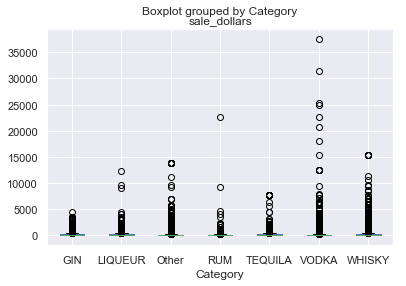

In [48]:
# pandas has some really powerful extensions to matplotlib for scientific computing 
ax = df.boxplot(column = 'sale_dollars', by = 'Category')
ax



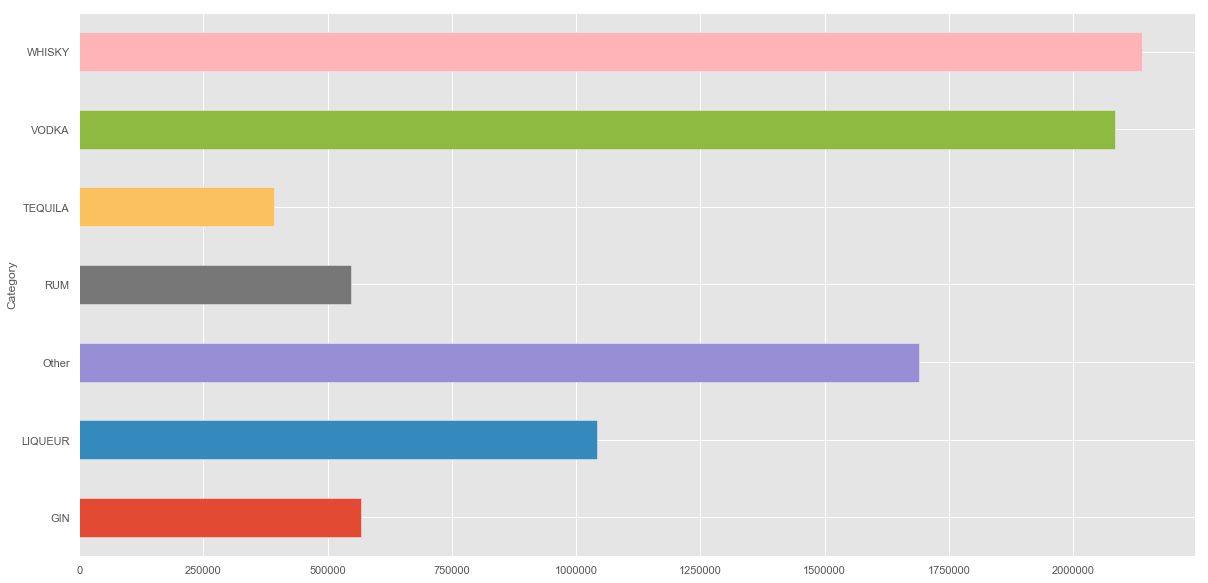

In [32]:
# Start by just plotting what we previsously grouped!
plt.style.use('ggplot')
plt.figure(figsize=(20,10))
df_grouped = df.groupby(by=['Category'])
sales_rate = df_grouped.sale_dollars.sum()
ax = sales_rate.plot(kind='barh')

In [65]:
df_grouped.head()

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,...,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,Category,store_parent,month,year,monthyear


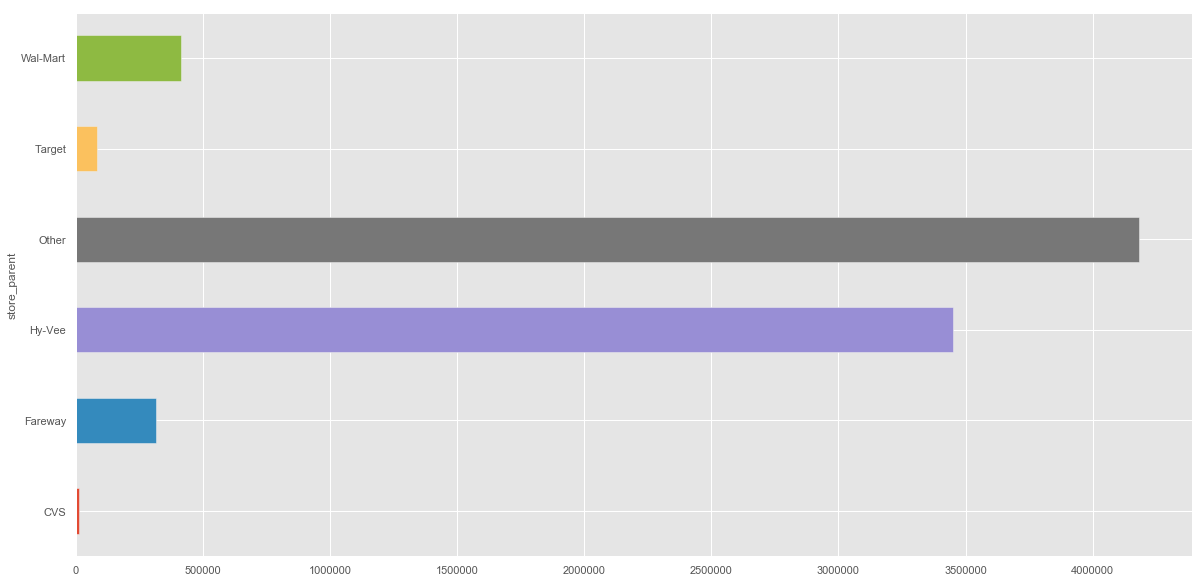

In [37]:
# Start by just plotting what we previsously grouped!
plt.style.use('ggplot')
plt.figure(figsize=(20,10))
df_grouped = df.groupby(by=['store_parent'])
sales_rate = df_grouped.sale_dollars.sum()
ax = sales_rate.plot(kind='barh')

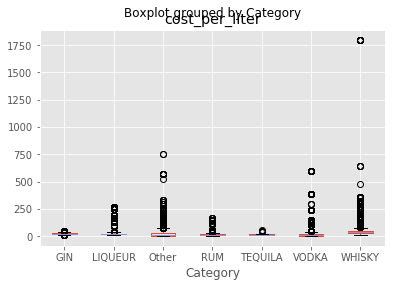

In [16]:
df['cost_per_liter'] = df['sale_dollars']/df['volume_sold_liters']


bx = df.boxplot(column = 'cost_per_liter', by = 'Category')
bx

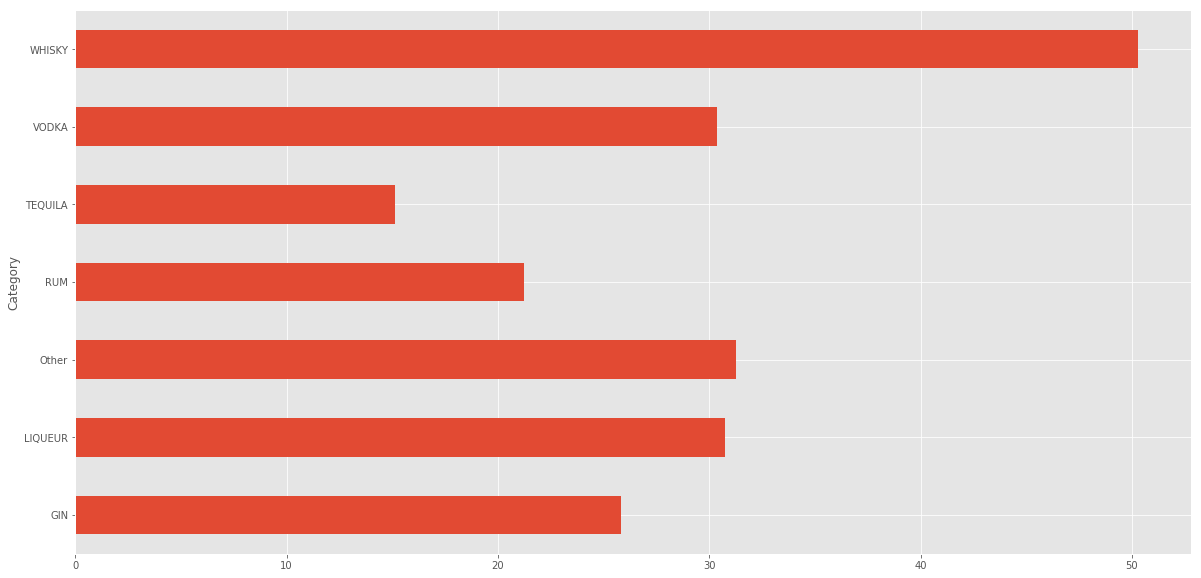

In [17]:
# Start by just plotting what we previsously grouped!
plt.style.use('ggplot')
plt.figure(figsize=(20,10))
df_grouped = df.groupby(by=['Category'])
sales_rate = df_grouped.cost_per_liter.mean()
ax = sales_rate.plot(kind='barh')

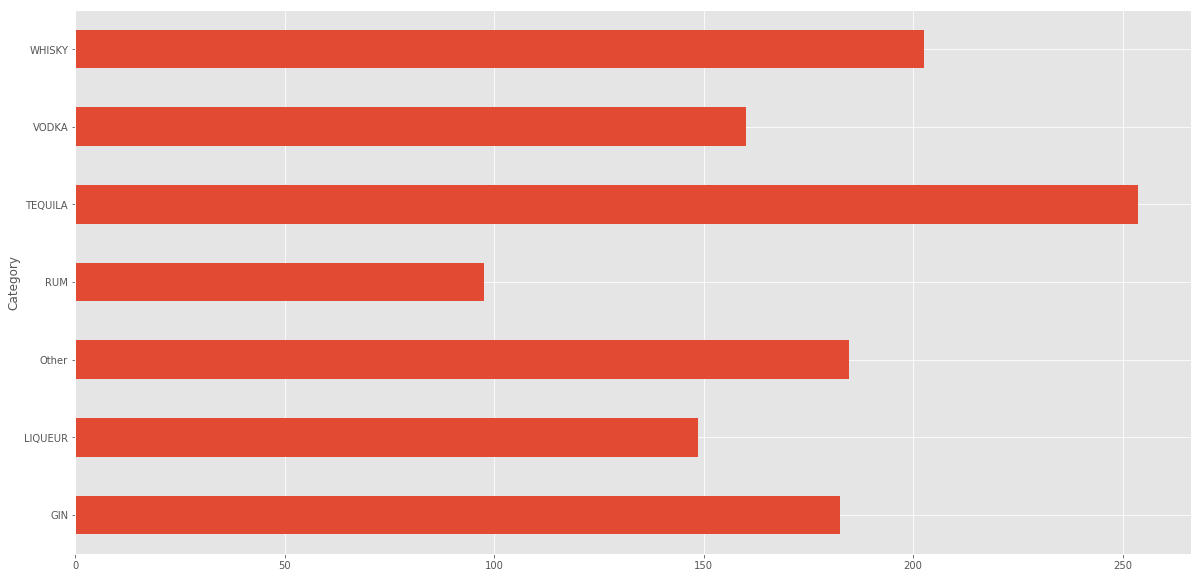

In [18]:
# Start by just plotting what we previsously grouped!
plt.style.use('ggplot')
plt.figure(figsize=(20,10))
df_grouped = df.groupby(by=['Category'])
sales_rate = df_grouped.sale_dollars.mean()
ax = sales_rate.plot(kind='barh')

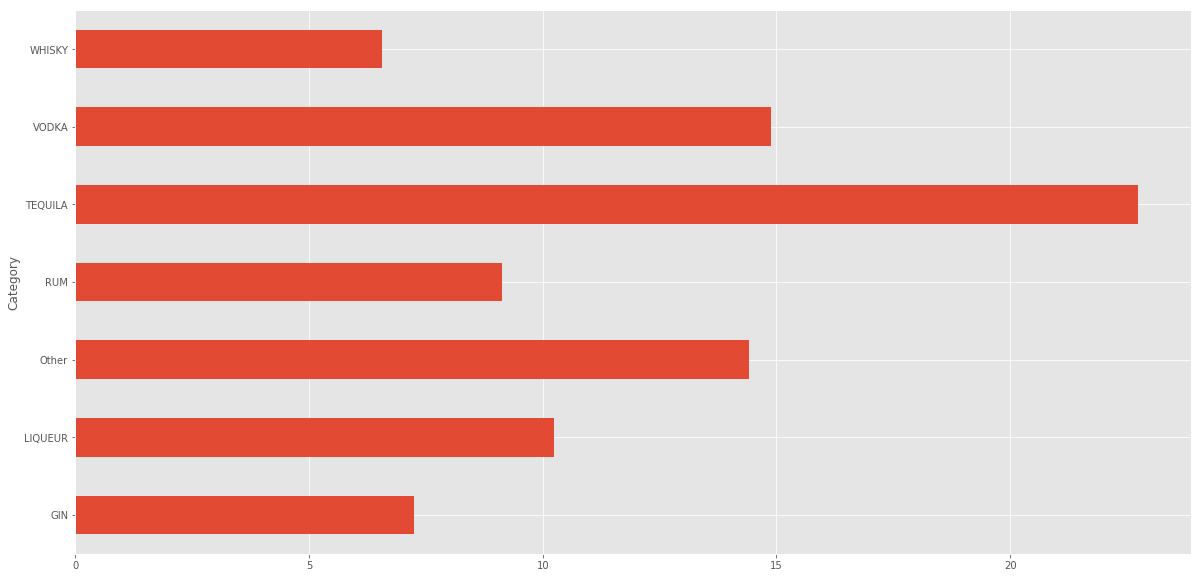

In [19]:
# Start by just plotting what we previsously grouped!
plt.style.use('ggplot')
plt.figure(figsize=(20,10))
df_grouped = df.groupby(by=['Category'])
sales_rate = df_grouped.bottles_sold.mean()
ax = sales_rate.plot(kind='barh')

In [75]:
#analyze only whiskey
#seperate dataframe limited to whiskey
dfwhiskey = pd.read_csv(r'/Users/jjschued/Documents/Github/7331DataMiningNotebooks/lab1/iowa_subset_2019_400k_random_rows.csv')

#convert nan to blanks
dfwhiskey = (dfwhiskey.replace(r'^\s*$', np.nan, regex=True))
dfwhiskey = (dfwhiskey.replace(np.nan, 'blank', regex=True))

#upper case category name for matching later
dfwhiskey['category_name'] = dfwhiskey['category_name'].str.upper()

#grouping all the store locations into parent stores
dfwhiskey['Category'] = 'Other'
dfwhiskey.loc[dfwhiskey['category_name'].str.contains('GINS'), 'Category'] = 'GIN'
dfwhiskey.loc[dfwhiskey['category_name'].str.contains('GINS'), 'Category'] = 'GIN'
dfwhiskey.loc[dfwhiskey['category_name'].str.contains('GIN'), 'Category'] = 'GIN'
dfwhiskey.loc[dfwhiskey['category_name'].str.contains('RUMS'), 'Category'] = 'RUM'
dfwhiskey.loc[dfwhiskey['category_name'].str.contains('RUM'), 'Category'] = 'RUM'
dfwhiskey.loc[dfwhiskey['category_name'].str.contains('SCOTCH'), 'Category'] = 'WHISKY'
dfwhiskey.loc[dfwhiskey['category_name'].str.contains('WHISKIES'), 'Category'] = 'WHISKY'
dfwhiskey.loc[dfwhiskey['category_name'].str.contains('WHISKY'), 'Category'] = 'WHISKY'
dfwhiskey.loc[dfwhiskey['category_name'].str.contains('WHISKEY'), 'Category'] = 'WHISKY'
dfwhiskey.loc[dfwhiskey['category_name'].str.contains('RYE'), 'Category'] = 'WHISKY'
dfwhiskey.loc[dfwhiskey['category_name'].str.contains('AMARETTO'), 'Category'] = 'AMARETTO'
dfwhiskey.loc[dfwhiskey['category_name'].str.contains('BOURBON'), 'Category'] = 'WHISKY'
dfwhiskey.loc[dfwhiskey['category_name'].str.contains('LIQUEURS'), 'Category'] = 'LIQUEUR'
dfwhiskey.loc[dfwhiskey['category_name'].str.contains('LIQUEUR'), 'Category'] = 'LIQUEUR'
dfwhiskey.loc[dfwhiskey['category_name'].str.contains('VODKAS'), 'Category'] = 'VODKA'
dfwhiskey.loc[dfwhiskey['category_name'].str.contains('VODKA'), 'Category'] = 'VODKA'
dfwhiskey.loc[dfwhiskey['category_name'].str.contains('BRANDY'), 'Category'] = 'BRANDY'
dfwhiskey.loc[dfwhiskey['category_name'].str.contains('BRANDIES'), 'Category'] = 'GIN'
dfwhiskey.loc[dfwhiskey['category_name'].str.contains('CREME'), 'Category'] = 'SCHNAPPS'
dfwhiskey.loc[dfwhiskey['category_name'].str.contains('SCHNAPPS'), 'Category'] = 'SCHNAPPS'
dfwhiskey.loc[dfwhiskey['category_name'].str.contains('TEQUILA'), 'Category'] = 'TEQUILA'
dfwhiskey.loc[dfwhiskey['category_name'].str.contains('TEQUILAS'), 'Category'] = 'TEQUILA'

#get a few stray not available categories per internet this is tequila
dfwhiskey.loc[dfwhiskey['item_description'] == 'Herradura Gold Reposado 6pak', 'Category'] = "Tequila"
dfwhiskey.loc[dfwhiskey['item_description'] == 'Chambord Liqueur w/2 Glasses', 'Category'] = "Liquers"

#grouping all the store locations into parent stores
dfwhiskey['store_parent'] = 'Other'
dfwhiskey.loc[dfwhiskey['store_name'].str.contains('Hy-Vee'), 'store_parent'] = 'Hy-Vee'
dfwhiskey.loc[dfwhiskey['store_name'].str.contains('Wal-Mart'), 'store_parent'] = 'Wal-Mart'
dfwhiskey.loc[dfwhiskey['store_name'].str.contains('SamsClub'), 'store_parent'] = 'SamsClub'
dfwhiskey.loc[dfwhiskey['store_name'].str.contains('Fareway'), 'store_parent'] = 'Fareway'
dfwhiskey.loc[dfwhiskey['store_name'].str.contains('Kum&Go'), 'store_parent'] = 'Kum&Go'
dfwhiskey.loc[dfwhiskey['store_name'].str.contains('CVS'), 'store_parent'] = 'CVS'
dfwhiskey.loc[dfwhiskey['store_name'].str.contains('Target'), 'store_parent'] = 'Target'
dfwhiskey.loc[dfwhiskey['store_name'].str.contains('Caseys'), 'store_parent'] = 'Caseys'
dfwhiskey.loc[dfwhiskey['store_name'].str.contains('Dahls'), 'store_parent'] = 'Dahls'
dfwhiskey.loc[dfwhiskey['store_name'].str.contains('WAL-MART'), 'store_parent'] = 'Wal-Mart'
dfwhiskey.loc[dfwhiskey['store_name'].str.contains('HY-VEE'), 'store_parent'] = 'Hy-Vee'
dfwhiskey.loc[dfwhiskey['store_name'].str.contains('KUM&GO'), 'store_parent'] = 'Kum&Go'
dfwhiskey.loc[dfwhiskey['store_name'].str.contains('QuikTrip'), 'store_parent'] = 'QuikTrip'


#labored conversion of dates to month year and month year by converting to strings
dfwhiskey['month'] = pd.DatetimeIndex(dfwhiskey['date']).month
dfwhiskey['year'] = pd.DatetimeIndex(dfwhiskey['date']).year

dfwhiskey.loc[dfwhiskey['month'] ==1 , 'month'] = 'Jan'
dfwhiskey.loc[dfwhiskey['month'] ==2 , 'month'] = 'Feb'
dfwhiskey.loc[dfwhiskey['month'] ==3 , 'month'] = 'Mar'
dfwhiskey.loc[dfwhiskey['month'] ==4 , 'month'] = 'Apr'
dfwhiskey.loc[dfwhiskey['month'] ==5 , 'month'] = 'May'
dfwhiskey.loc[dfwhiskey['month'] ==6 , 'month'] = 'Jun'
dfwhiskey.loc[dfwhiskey['month'] ==7 , 'month'] = 'Jul'
dfwhiskey.loc[dfwhiskey['month'] ==8 , 'month'] = 'Aug'
dfwhiskey.loc[dfwhiskey['month'] ==9 , 'month'] = 'Sep'
dfwhiskey.loc[dfwhiskey['month'] ==10 , 'month'] = 'Oct'
dfwhiskey.loc[dfwhiskey['month'] ==11 , 'month'] = 'Nov'
dfwhiskey.loc[dfwhiskey['month'] ==12 , 'month'] = 'Dec'


dfwhiskey.loc[dfwhiskey['year'] ==2012 , 'year'] = '2012'
dfwhiskey.loc[dfwhiskey['year'] ==2013 , 'year'] = '2013'
dfwhiskey.loc[dfwhiskey['year'] ==2014 , 'year'] = '2014'
dfwhiskey.loc[dfwhiskey['year'] ==2015 , 'year'] = '2015'
dfwhiskey.loc[dfwhiskey['year'] ==2016 , 'year'] = '2016'
dfwhiskey.loc[dfwhiskey['year'] ==2017 , 'year'] = '2017'
dfwhiskey.loc[dfwhiskey['year'] ==2018 , 'year'] = '2018'
dfwhiskey.loc[dfwhiskey['year'] ==2019 , 'year'] = '2019'

#merge year and month together
dfwhiskey['monthyear'] = dfwhiskey['month'] + "-" + dfwhiskey['year']


In [76]:
dfwhiskey.head()

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,...,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,Category,store_parent,month,year,monthyear
0,INV-23084400002,2019-11-07,3869,Bootleggin' Barzini's Fin,412 1st Ave,Coralville,52241,POINT (-91.565517 41.672672),52,JOHNSON,...,5.78,20,115.60,7.50,1.98,Other,Other,Nov,2019,Nov-2019
1,INV-23282200001,2019-11-18,4617,Lickety Liquor,2501 HUBBELL AVE,Des Moines,50317,POINT (-93.570489 41.607817),77,POLK,...,13.13,1,13.13,0.05,0.01,Other,Other,Nov,2019,Nov-2019
2,INV-19435800130,2019-05-17,2560,Hy-Vee Food Store / Marion,3600 Business Hwy 151 East,Marion,52302,blank,57,LINN,...,24.75,6,148.50,6.00,1.58,GIN,Hy-Vee,May,2019,May-2019
3,INV-23454200002,2019-11-25,2614,Hy-Vee #3 Food & Drugstore / Davenport,1823 E Kimberly Rd,Davenport,52807,POINT (-90.548919 41.55678100000001),82,SCOTT,...,31.76,24,762.24,18.00,4.75,WHISKY,Hy-Vee,Nov,2019,Nov-2019
4,INV-23541200001,2019-11-27,2629,Hy-Vee Food Store #2 / Council Bluffs,1745 Madison Ave,Council Bluffs,51503,POINT (-95.825137 41.242732),78,POTTAWATTA,...,13.97,12,167.64,21.00,5.54,Other,Hy-Vee,Nov,2019,Nov-2019


In [84]:
dfwhiskey = dfwhiskey[dfwhiskey['Category']=='WHISKY']

In [85]:
dfwhiskey.head()

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,...,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,Category,store_parent,month,year,monthyear
3,INV-23454200002,2019-11-25,2614,Hy-Vee #3 Food & Drugstore / Davenport,1823 E Kimberly Rd,Davenport,52807,POINT (-90.548919 41.55678100000001),82,SCOTT,...,31.76,24,762.24,18.0,4.75,WHISKY,Hy-Vee,Nov,2019,Nov-2019
5,INV-23540300028,2019-11-27,4312,I-80 Liquor / Council Bluffs,2411 S 24TH ST #1,Council Bluffs,51501,POINT (-95.8792 41.238092),78,POTTAWATTA,...,43.47,6,260.82,6.0,1.58,WHISKY,Other,Nov,2019,Nov-2019
15,INV-19970300001,2019-06-13,2675,Hy-Vee #2 / Coralville,3285 Crosspark Rd,Coralville,52241,POINT (-91.60627100000002 41.721438),52,JOHNSON,...,32.39,18,583.02,13.5,3.56,WHISKY,Hy-Vee,Jun,2019,Jun-2019
24,INV-23645000007,2019-12-03,5866,Hometown Family Market,310 2nd St,Gladbrook,50635,POINT (-92.716422 42.187653),86,TAMA,...,31.50,2,63.00,2.0,0.52,WHISKY,Other,Dec,2019,Dec-2019
29,INV-19201600066,2019-05-07,2651,Hy-Vee / Waverly,1311 4 Street SW,Waverly,50677,POINT (-92.475403 42.712263),9,BREMER,...,27.14,30,814.20,22.5,5.94,WHISKY,Hy-Vee,May,2019,May-2019


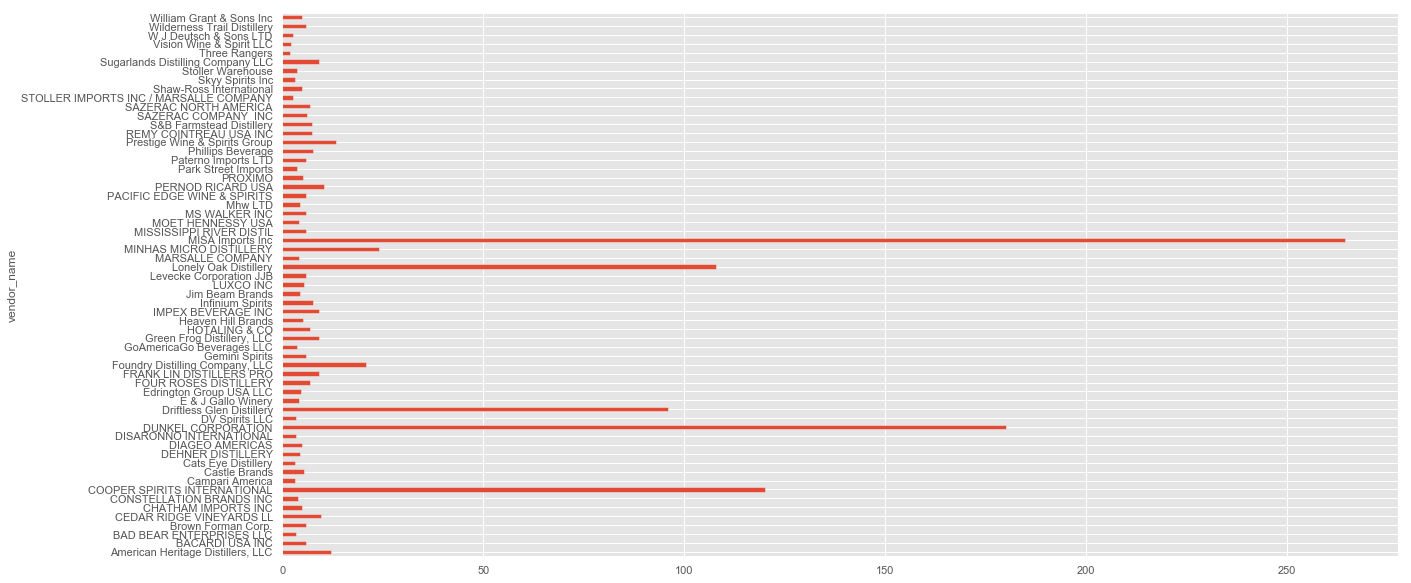

In [109]:
# Start by just plotting what we previsously grouped!
dfwhiskey['cost_per_liter'] = dfwhiskey['sale_dollars']/df['volume_sold_liters']
plt.style.use('ggplot')
plt.figure(figsize=(20,10))
df_grouped = dfwhiskey.groupby(by=['vendor_name'])
sales_rate = df_grouped.bottles_sold.mean()
ax = sales_rate.plot(kind='barh')

In [97]:
df_grouped = dfwhiskey.groupby(by=['vendor_name'])
df_grouped.head()

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,...,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,Category,store_parent,month,year,monthyear
3,INV-23454200002,2019-11-25,2614,Hy-Vee #3 Food & Drugstore / Davenport,1823 E Kimberly Rd,Davenport,52807,POINT (-90.548919 41.55678100000001),82,SCOTT,...,31.76,24,762.24,18.00,4.75,WHISKY,Hy-Vee,Nov,2019,Nov-2019
5,INV-23540300028,2019-11-27,4312,I-80 Liquor / Council Bluffs,2411 S 24TH ST #1,Council Bluffs,51501,POINT (-95.8792 41.238092),78,POTTAWATTA,...,43.47,6,260.82,6.00,1.58,WHISKY,Other,Nov,2019,Nov-2019
15,INV-19970300001,2019-06-13,2675,Hy-Vee #2 / Coralville,3285 Crosspark Rd,Coralville,52241,POINT (-91.60627100000002 41.721438),52,JOHNSON,...,32.39,18,583.02,13.50,3.56,WHISKY,Hy-Vee,Jun,2019,Jun-2019
24,INV-23645000007,2019-12-03,5866,Hometown Family Market,310 2nd St,Gladbrook,50635,POINT (-92.716422 42.187653),86,TAMA,...,31.50,2,63.00,2.00,0.52,WHISKY,Other,Dec,2019,Dec-2019
29,INV-19201600066,2019-05-07,2651,Hy-Vee / Waverly,1311 4 Street SW,Waverly,50677,POINT (-92.475403 42.712263),9,BREMER,...,27.14,30,814.20,22.50,5.94,WHISKY,Hy-Vee,May,2019,May-2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246015,INV-21252600005,2019-08-15,4129,Cyclone Liquors,626 Lincoln Way,Ames,50010,POINT (-93.618911 42.022854),85,STORY,...,45.00,6,270.00,4.50,1.18,WHISKY,Other,Aug,2019,Aug-2019
314264,INV-21229200003,2019-08-14,3773,Benz Distributing,501 7th Ave SE,Cedar Rapids,52401,POINT (-91.659875 41.97574),57,LINN,...,14.99,18,269.82,13.50,3.56,WHISKY,Other,Aug,2019,Aug-2019
314265,INV-17524000177,2019-02-13,4129,Cyclone Liquors,626 Lincoln Way,Ames,50010,POINT (-93.618911 42.022854),85,STORY,...,14.99,1,14.99,0.75,0.19,WHISKY,Other,Feb,2019,Feb-2019
314266,INV-19589600071,2019-05-24,3868,Wal-Mart 3630 / Marion,5491 Business Hwy 151,Marion,52302,blank,57,LINN,...,14.99,6,89.94,4.50,1.18,WHISKY,Wal-Mart,May,2019,May-2019


In [110]:
sales_rateq = df_grouped.bottles_sold.sum()
sales_rated = df_grouped.sale_dollars.sum()
sales_ratecpl = df_grouped.cost_per_liter.mean()

In [112]:
dfsr = pd.DataFrame(sales_rateq)
dfsdol = pd.DataFrame(sales_rated)
dfscpl = pd.DataFrame(sales_ratecpl)


In [114]:
dfsr.sort_values(by='bottles_sold', ascending=False).head(10)

,bottles_sold
vendor_name,
PERNOD RICARD USA,105068
DIAGEO AMERICAS,29552
Infinium Spirits,22497
William Grant & Sons Inc,15926
SAZERAC NORTH AMERICA,10698
SAZERAC COMPANY INC,10665
Jim Beam Brands,8651
BACARDI USA INC,7716
CEDAR RIDGE VINEYARDS LL,4411


In [115]:
dfsdol.sort_values(by='sale_dollars', ascending=False).head(10)

,sale_dollars
vendor_name,
PERNOD RICARD USA,2965631.76
DIAGEO AMERICAS,935867.44
Infinium Spirits,634224.71
William Grant & Sons Inc,509568.03
Jim Beam Brands,227406.10
BACARDI USA INC,216439.87
SAZERAC COMPANY INC,188508.57
Edrington Group USA LLC,185043.45
MOET HENNESSY USA,168206.25


In [116]:
dfscpl.sort_values(by='cost_per_liter', ascending=False).head(10)

,cost_per_liter
vendor_name,
PACIFIC EDGE WINE & SPIRITS,115.893333
IMPEX BEVERAGE INC,103.840000
HOTALING & CO,100.006667
W J Deutsch & Sons LTD,93.320000
GoAmericaGo Beverages LLC,89.010874
Mhw LTD,88.666667
"Foundry Distilling Company, LLC",80.000000
REMY COINTREAU USA INC,79.946667
Edrington Group USA LLC,75.627640


In [121]:
salesbyvendor = pd.merge(dfsr, dfsdol, how = 'left', on='vendor_name')
salesbyvendor = pd.merge(salesbyvendor, dfscpl, how = 'left', on='vendor_name')
salesbyvendor

,bottles_sold,sale_dollars,cost_per_liter
vendor_name,,,
"American Heritage Distillers, LLC",12,189.60,NaN
BACARDI USA INC,7716,216439.87,29.680629
BAD BEAR ENTERPRISES LLC,413,18987.00,63.814815
Brown Forman Corp.,2284,68098.15,42.744519
CEDAR RIDGE VINEYARDS LL,4411,142926.26,43.515578
...,...,...,...
Three Rangers,2,74.64,NaN
Vision Wine & Spirit LLC,54,2817.91,64.431795
W J Deutsch & Sons LTD,19,1329.81,93.320000


In [122]:
salesbyvendor.sort_values(by='cost_per_liter', ascending=False).head(10)

,bottles_sold,sale_dollars,cost_per_liter
vendor_name,,,
PACIFIC EDGE WINE & SPIRITS,36,3930.24,115.893333
IMPEX BEVERAGE INC,36,3681.12,103.840000
HOTALING & CO,48,3570.24,100.006667
W J Deutsch & Sons LTD,19,1329.81,93.320000
GoAmericaGo Beverages LLC,769,50006.25,89.010874
Mhw LTD,267,6866.10,88.666667
"Foundry Distilling Company, LLC",499,15221.40,80.000000
REMY COINTREAU USA INC,30,1385.04,79.946667
Edrington Group USA LLC,4200,185043.45,75.627640


In [124]:
salesbyvendor.sort_values(by='sale_dollars', ascending=False).head(10)

,bottles_sold,sale_dollars,cost_per_liter
vendor_name,,,
PERNOD RICARD USA,105068,2965631.76,54.869265
DIAGEO AMERICAS,29552,935867.44,65.450906
Infinium Spirits,22497,634224.71,38.306306
William Grant & Sons Inc,15926,509568.03,61.755663
Jim Beam Brands,8651,227406.10,39.015703
BACARDI USA INC,7716,216439.87,29.680629
SAZERAC COMPANY INC,10665,188508.57,28.119067
Edrington Group USA LLC,4200,185043.45,75.627640
MOET HENNESSY USA,3993,168206.25,70.010080


<Figure size 1440x720 with 0 Axes>

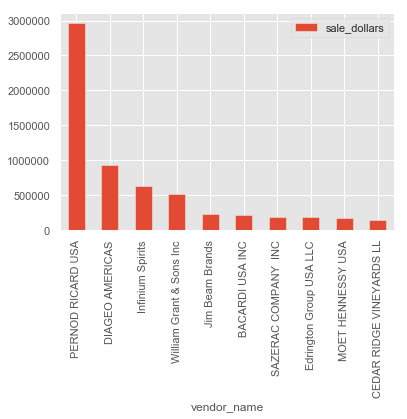

In [130]:
# Start by just plotting what we previsously grouped!
plt.style.use('ggplot')
plt.figure(figsize=(20,10))
sales_rate = dfsdol.sort_values(by='sale_dollars', ascending=False).head(10)
ax = sales_rate.plot(kind='bar')

<Figure size 1440x720 with 0 Axes>

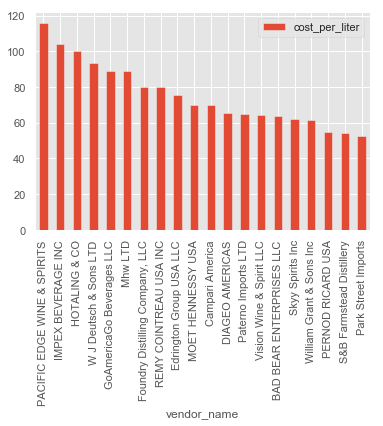

In [128]:
# Start by just plotting what we previsously grouped!
plt.style.use('ggplot')
plt.figure(figsize=(20,10))
sales_rate = dfscpl.sort_values(by='cost_per_liter', ascending=False).head(20)
ax = sales_rate.plot(kind='bar')

## Explore Joint Attributes
Visualize relationships between attributes: Look at the attributes via scatter plots, correlation, cross-tabulation, group-wise averages, etc. as appropriate. Explain any interesting relationships.



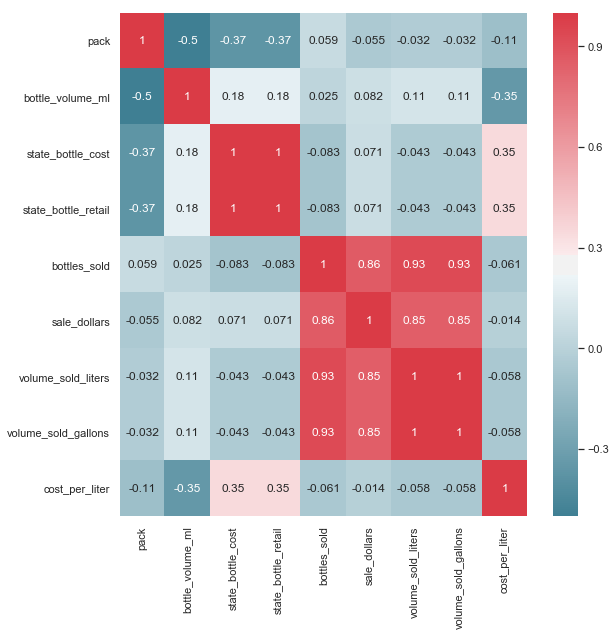

In [40]:
# plot the correlation matrix using seaborn
import seaborn as sns
cmap = sns.diverging_palette(220, 10, as_cmap=True) # one of the many color mappings

sns.set(style="darkgrid") # one of the many styles to plot using
f, ax = plt.subplots(figsize=(9, 9))
sns.heatmap(df.corr(), cmap=cmap, annot=True)
f.tight_layout()

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


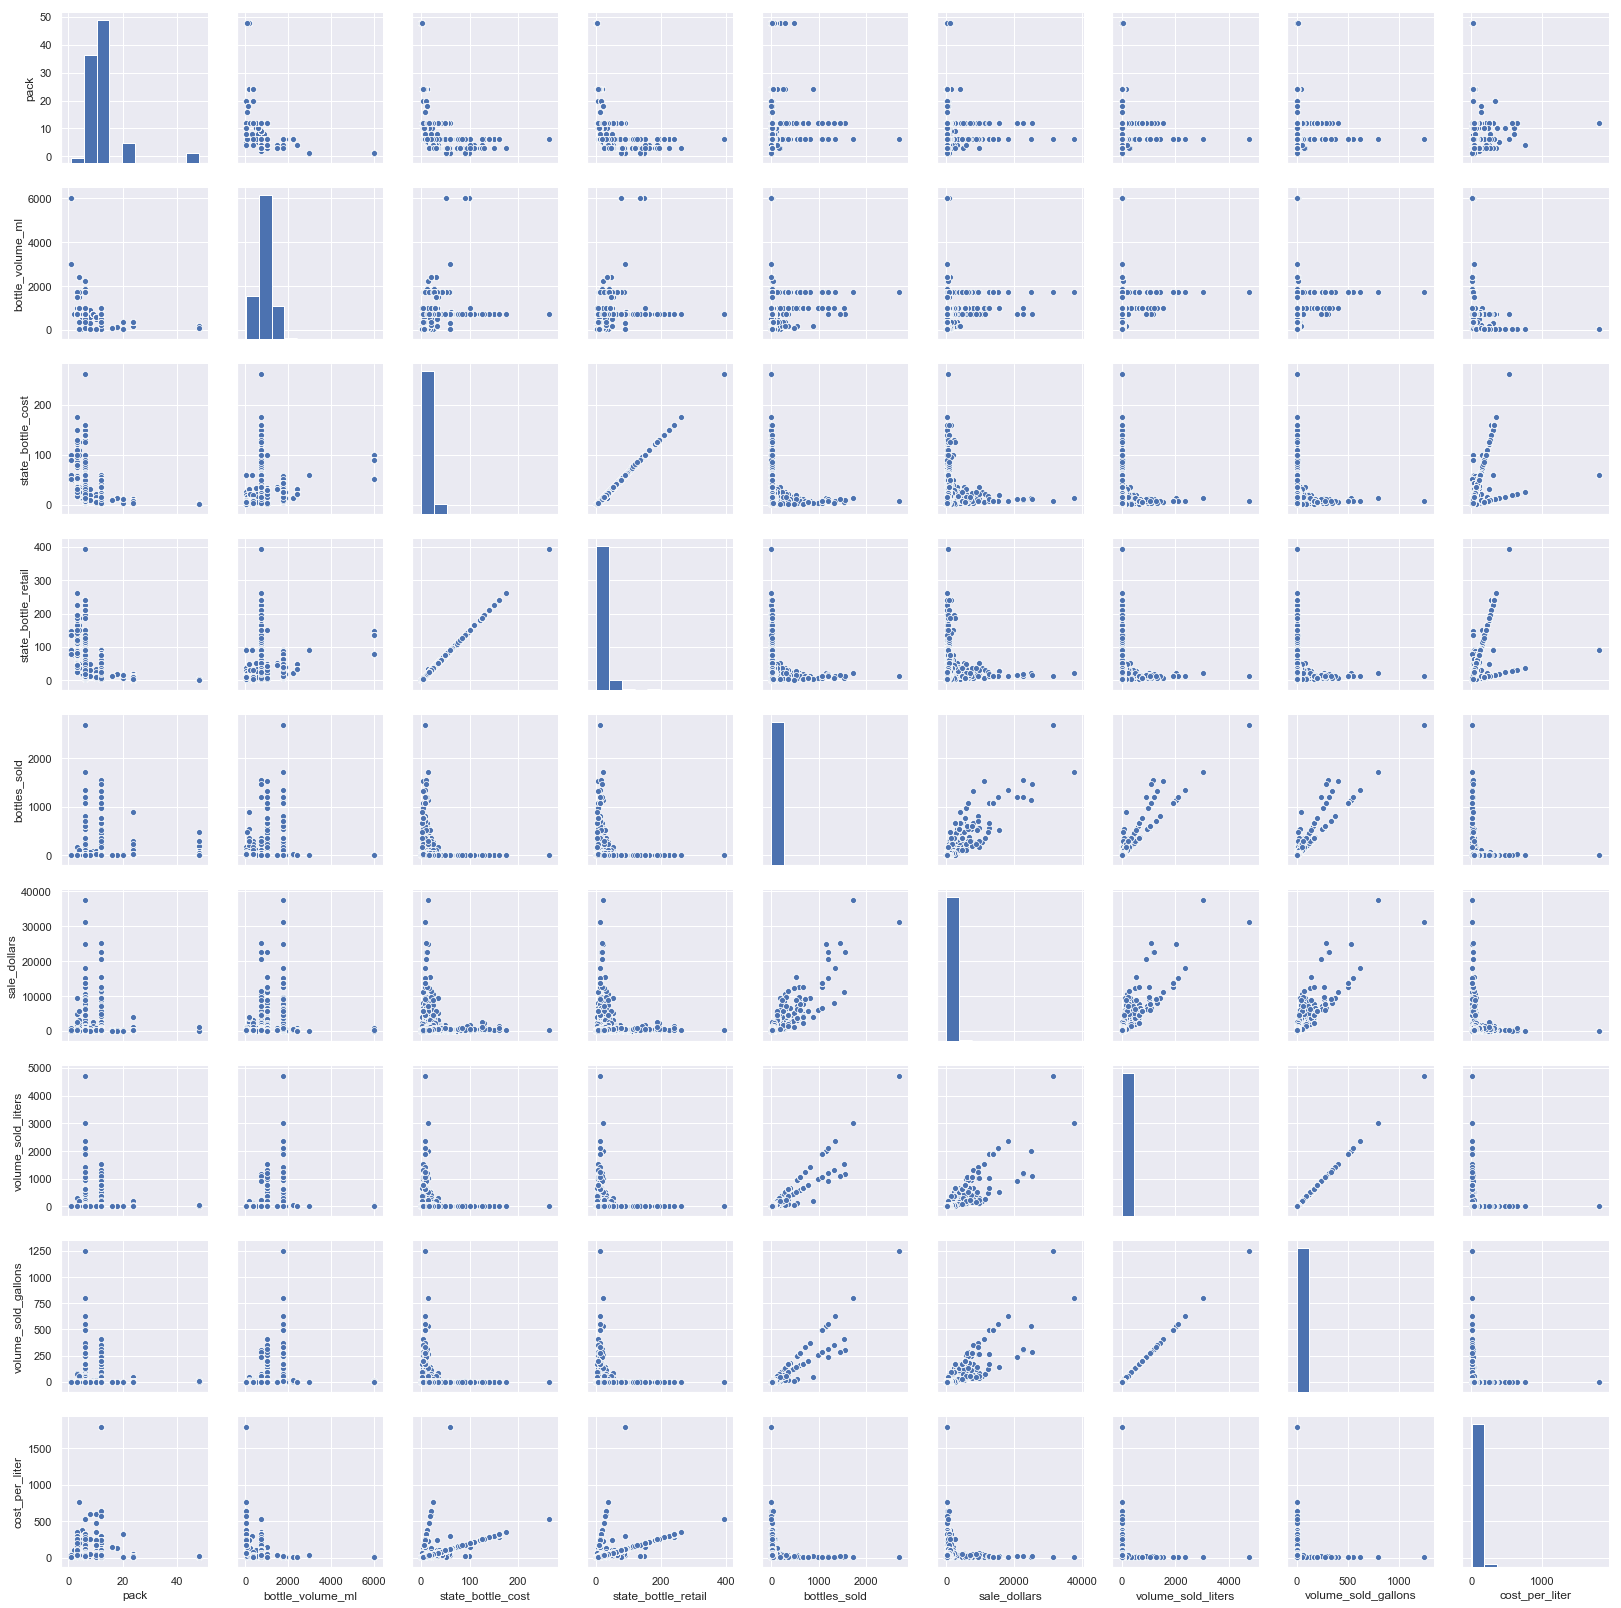

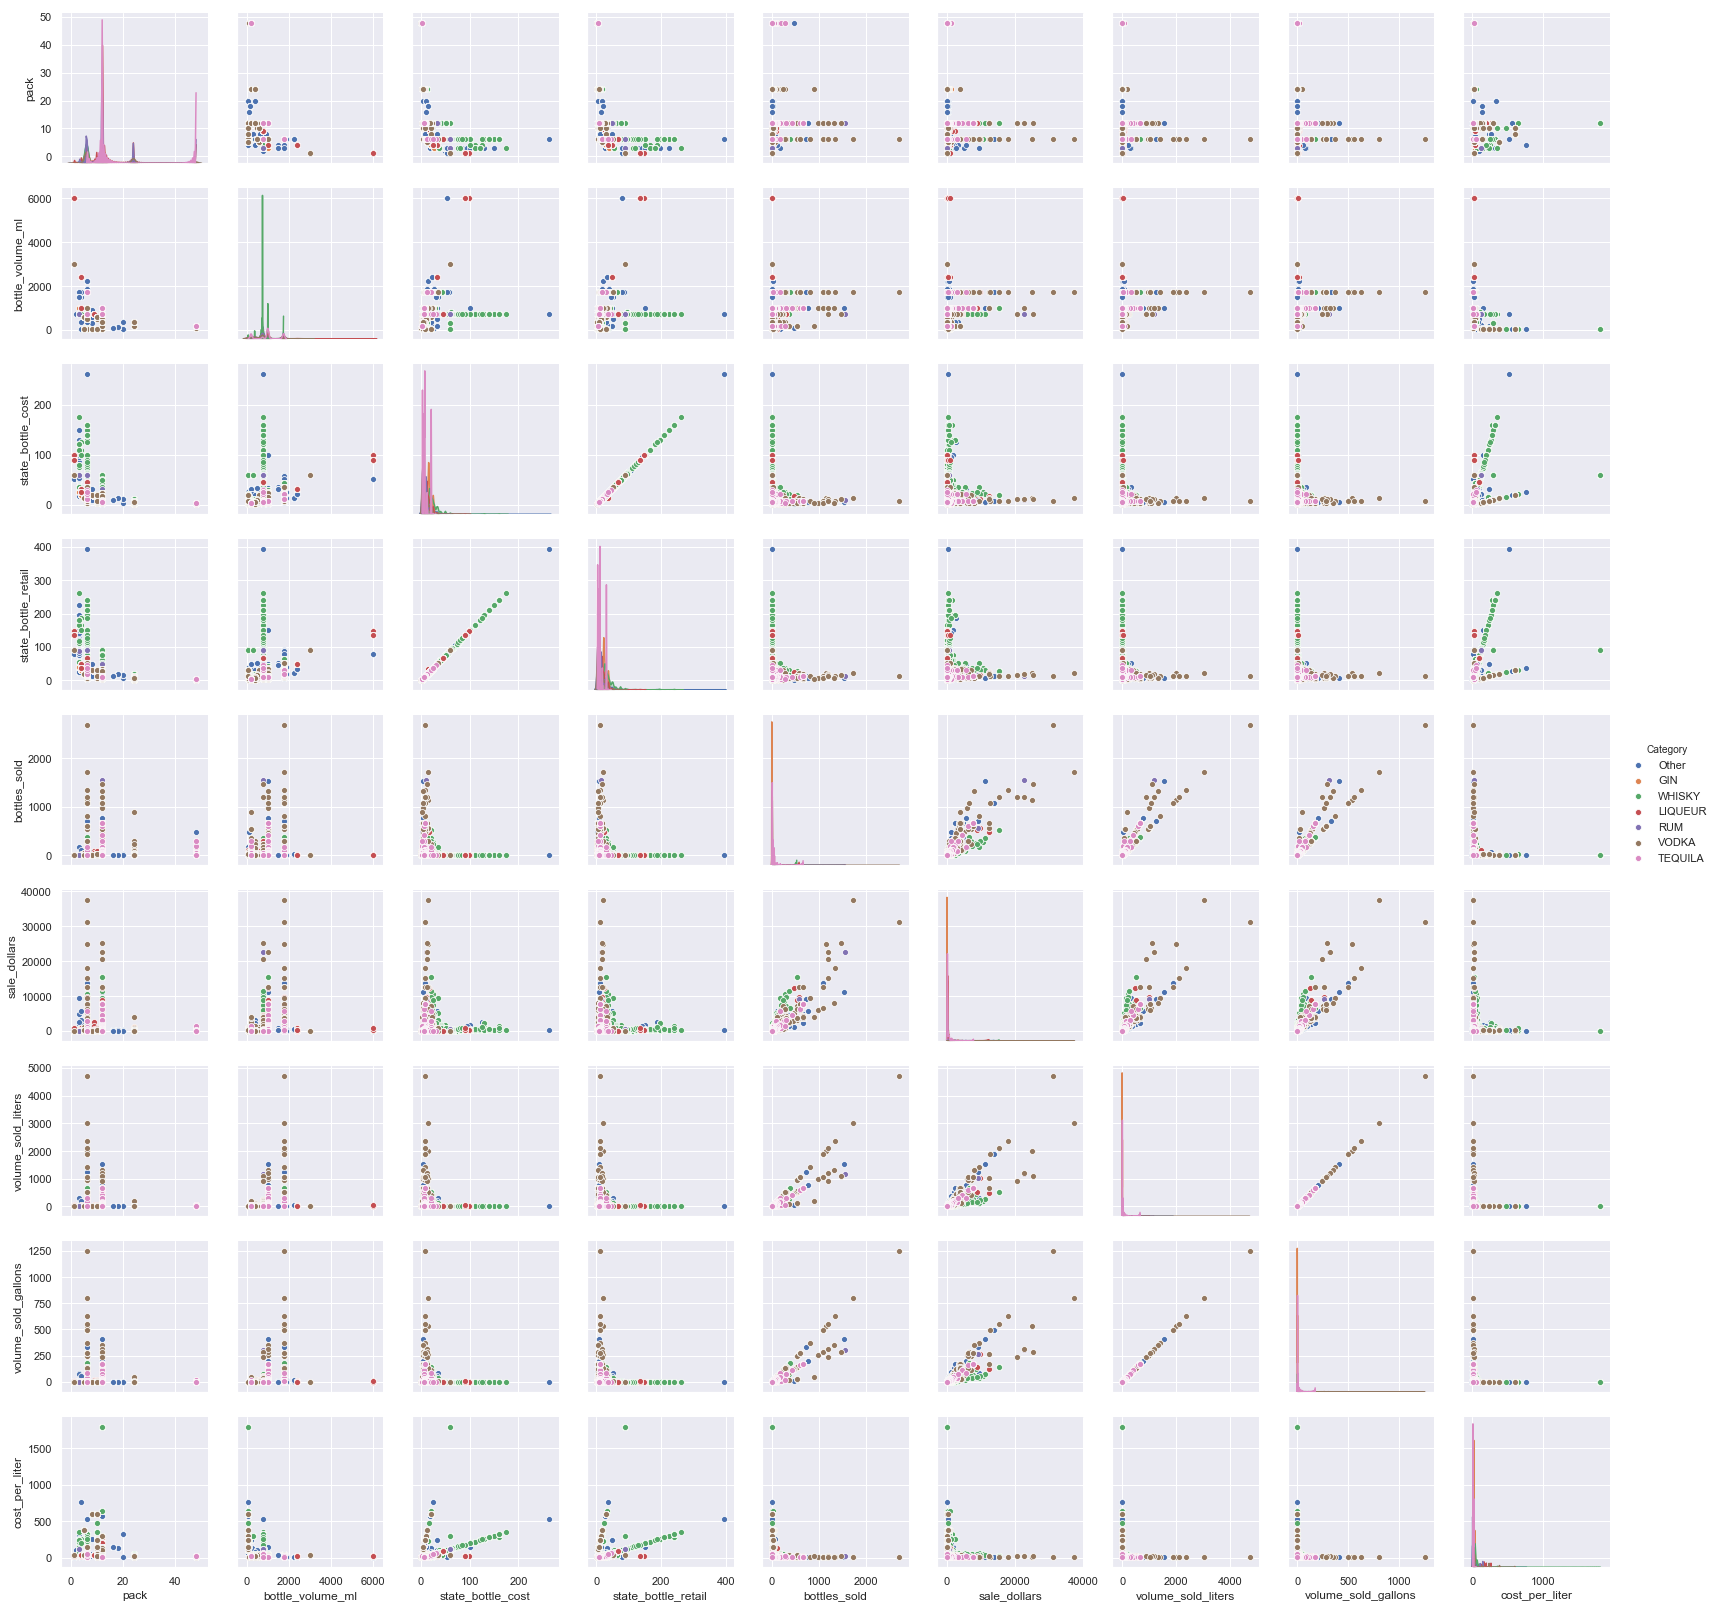

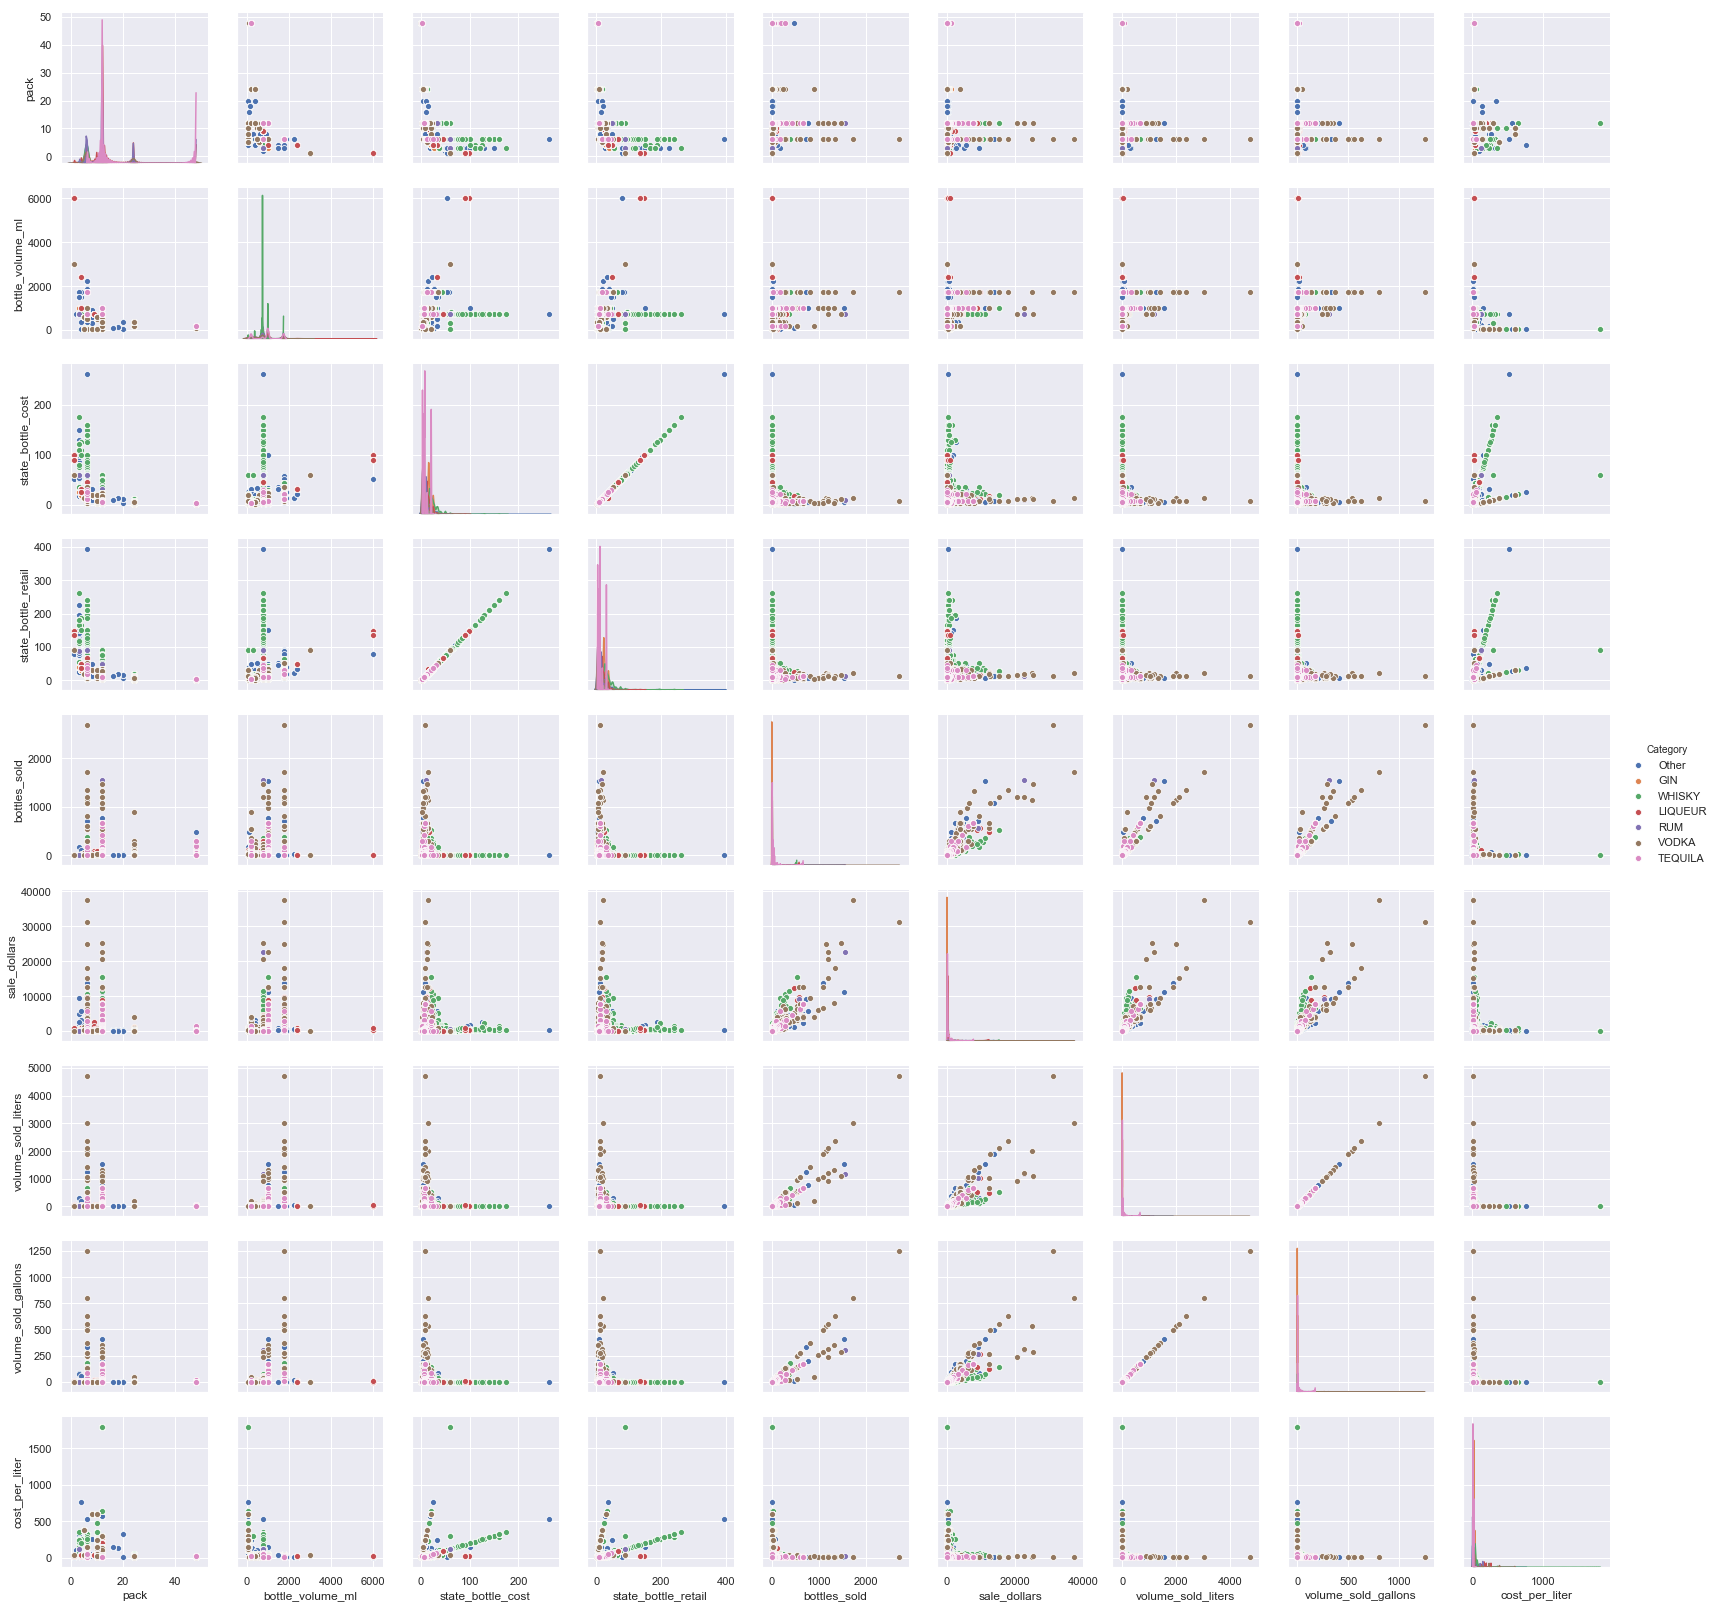

In [50]:
# now try plotting some of the previous plots, way more visually appealing!!
#https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166
sns.pairplot(df)
sns.pairplot(df, hue= 'Category')
sns.pairplot(df, hue='Category', diag_kind = 'kde')

In [30]:
#cross tab example
dfcross = pd.crosstab(df['Category'], df['store_parent'],  margins=True, margins_name="Total")
dfcross

store_parent,CVS,Fareway,Hy-Vee,Other,Target,Wal-Mart,Total
Category,,,,,,,
GIN,8,109,1499,1391,34,60,3101
LIQUEUR,7,313,2424,3856,42,365,7007
Other,5,688,3570,4245,111,536,9155
RUM,4,205,2231,2770,18,380,5608
TEQUILA,2,89,538,849,2,66,1546
VODKA,48,534,4409,7486,93,457,13027
WHISKY,36,545,5112,4496,133,234,10556
Total,110,2483,19783,25093,433,2098,50000


In [31]:
#Normalized Cross Tab
dfcrossnorm = pd.crosstab(df['Category'], df['store_parent'], normalize='columns')
dfcrossnorm

store_parent,CVS,Fareway,Hy-Vee,Other,Target,Wal-Mart
Category,,,,,,
GIN,0.072727,0.043899,0.075772,0.055434,0.078522,0.028599
LIQUEUR,0.063636,0.126057,0.122529,0.153668,0.096998,0.173975
Other,0.045455,0.277084,0.180458,0.169171,0.256351,0.255481
RUM,0.036364,0.082561,0.112774,0.110389,0.041570,0.181125
TEQUILA,0.018182,0.035844,0.027195,0.033834,0.004619,0.031459
VODKA,0.436364,0.215062,0.222868,0.298330,0.214781,0.217827
WHISKY,0.327273,0.219493,0.258404,0.179173,0.307159,0.111535


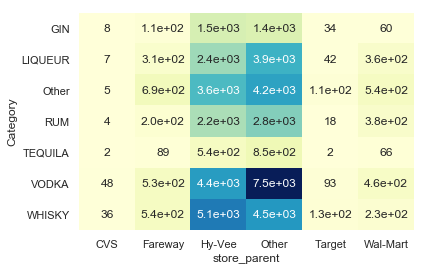

In [34]:
sns.heatmap(pd.crosstab([df['Category']], [df['store_parent']]),
            cmap="YlGnBu", annot=True, cbar=False)

In [41]:
#group wise average
df_grouped = df.groupby(by=['Category', 'store_parent']).mean()
df_grouped

pack  bottle_volume_ml  state_bottle_cost  \
Category store_parent                                                   
GIN      CVS            6.000000       1500.000000          23.213750   
         Fareway        9.724771        966.743119          15.144128   
         Hy-Vee         9.871915        998.165444          16.504163   
         Other         10.900072        988.048167          16.499619   
         Target         6.352941       1102.941176          21.179118   
         Wal-Mart       7.600000       1437.500000          21.564167   
LIQUEUR  CVS            9.428571       1178.571429          15.342857   
         Fareway       11.702875        788.099042          10.901534   
         Hy-Vee        12.786304        845.348597          11.646233   
         Other         15.800571        748.839471          10.421203   
         Target         6.476190       2241.666667          31.869762   
         Wal-Mart      10.624658       1089.109589          13.833041   
Other    CVS            6.000000       1350.000000          17.336000   
         Fareway        9.029070        906.031977          13.434259   
         Hy-Vee         9.114286        936.555462          11.683818   
         Other          8.979505        905.783274          13.332327   
         Target         7.315315        896.396396          13.642973   
         Wal-Mart       8.089552       1197.201493          10.238060   
RUM      CVS           10.500000       1000.000000          12.280000   
         Fareway       11.619512        850.975610           8.917317   
         Hy-Vee        13.126401        860.466159           9.016746   
         Other         16.952347        736.263538           7.479715   
         Target         8.333333       1361.111111          14.971111   
         Wal-Mart       7.942105       1307.894737          10.697132   
TEQUILA  CVS            6.000000       1750.000000          21.000000   
         Fareway       10.179775       1089.887640          10.514494   
         Hy-Vee        18.100372        968.959108           8.833792   
         Other         20.650177        918.021201           8.474535   
         Target         6.000000       1750.000000          21.000000   
         Wal-Mart       6.909091       1636.363636          19.004545   
VODKA    CVS            7.875000       1471.354167          10.402917   
         Fareway        9.825843       1020.271536           9.361067   
         Hy-Vee        12.216149        939.589476           8.799438   
         Other         13.545418        779.598584           8.349504   
         Target         6.903226       1470.430108          14.372688   
         Wal-Mart       8.669584       1343.544858          13.105580   
WHISKY   CVS            9.666667       1079.861111          18.844722   
         Fareway        8.957798        859.174312          20.123450   
         Hy-Vee         9.239437        814.343701          24.091148   
         Other          9.703069        826.657028          23.928570   
         Target         7.984962        838.345865          21.655789   
         Wal-Mart       8.205128        969.764957          19.535214   

                       state_bottle_retail  bottles_sold  sale_dollars  \
Category store_parent                                                    
GIN      CVS                     34.823750      4.125000    143.775000   
         Fareway                 22.718899      4.798165    104.615321   
         Hy-Vee                  24.758432      6.913276    170.531301   
         Other                   24.751459      7.803019    200.057254   
         Target                  31.769412      6.352941    198.344118   
         Wal-Mart                32.350333      7.600000    217.192000   
LIQUEUR  CVS                     23.017143      7.428571    166.305714   
         Fareway                 16.355367     10.166134    144.102620   
         Hy-Vee                  17.477496      9.596947    154.853973   
 

## Explore Attributes and Class
Identify and explain interesting relationships between features and the class you are trying to predict (i.e., relationships with variables and the target classification).



## New Features 
Are there other features that could be added to the data or created from existing features? Which ones?



Day of the week
education
median population
income groups
age groups
employment
Grouping of Liquor Brands

## Exceptional Work 
You have free reign to provide additional analyses. One idea: implement dimensionality reduction, then visualize and interpret the results.